<a href="https://colab.research.google.com/github/XANDOOM/XANDOOM/blob/main/AD_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing required libraries

In [30]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import tensorflow as tf
from tensorflow import keras 
from keras import layers
import os
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive
import cv2
import glob
import pickle
from sklearn.cluster import KMeans
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model

from google.colab import drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/College/Cars/'

COLAB_DIR = '/content/'
GT_DIR = COLAB_DIR + 'gtFine/gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/leftImg8bit/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
!pip install cityscapesscripts
from cityscapesscripts.download import downloader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 472 kB 5.2 MB/s 
     |████████████████████████████████| 46 kB 4.7 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=71b03b53ea9349beefd56313e946b26fb1b06adb872ce19c3ff271ea8c5e4318
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing


## Getting the data

In [4]:
session = downloader.login()
# data for semantic segmentation task
print('Downloading gtFine and leftImg8bit \n')
package_list =['gtFine_trainvaltest.zip', 'leftImg8bit_trainvaltest.zip']
downloader.download_packages(session=session, package_names=package_list, destination_path=COLAB_DIR)

Cityscapes username or email address: XANDOOM
Cityscapes password: ··········
Store credentials unencrypted in '/root/.local/share/cityscapesscripts/credentials.json' [y/N]: y



In [5]:
!unzip -q gtFine_trainvaltest.zip -d gtFine #unzip and save by these names
!unzip -q leftImg8bit_trainvaltest.zip -d leftImg

#### Preprocess

In [6]:
# collapse child directories
for parent in listdir(GT_DIR): #files
    parent_dir = GT_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            keep = glob.glob(join(parent_dir, child) + '/*_gtFine_color.png') #outer wildcard
            keep = [f.split('/')[-1] for f in keep] #name
            for filename in list(set(listdir(join(parent_dir, child))) & set(keep)): #unique
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

for parent in listdir(IMG_DIR): #same
    parent_dir = IMG_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            for filename in listdir(join(parent_dir, child)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

In [7]:
# process and archive image in smaller size
def resize_image(path):
    img = Image.open(path)
    img.thumbnail(IMG_SHAPE)
    out_file = join(path)
    img.save(out_file, 'PNG')

In [8]:
IMG_SHAPE = 128, 128

gt_train_paths = [GT_DIR+'train/' + path for path in listdir(GT_DIR+'train/')]
gt_test_paths = [GT_DIR+'test/' + path for path in listdir(GT_DIR+'test/')]
gt_val_paths = [GT_DIR+'val/' + path for path in listdir(GT_DIR+'val/')]
gt_paths = gt_train_paths + gt_test_paths + gt_val_paths

for img in gt_paths:
    resize_image(img)
make_archive('gtFine', 'zip', GT_DIR)

'/content/gtFine.zip'

In [9]:
im_train_paths = [IMG_DIR+'train/' + path for path in listdir(IMG_DIR+'train/')]
im_test_paths = [IMG_DIR+'test/' + path for path in listdir(IMG_DIR+'test/')]
im_val_paths = [IMG_DIR+'val/' + path for path in listdir(IMG_DIR+'val/')]
im_paths = im_train_paths + im_test_paths + im_val_paths

for img in im_paths:
    resize_image(img)
make_archive('leftImg', 'zip', IMG_DIR)

'/content/leftImg.zip'

#### **Load Archived Data** 
( Downloaded the archived data for later sessions to avoid having to download and preprocess again)

In [6]:
gt_file, gt_dir = join(COLAB_DIR + 'gtFine.zip'), join(COLAB_DIR + 'gtFine/')
!unzip -q $gt_file -d $gt_dir

im_file, im_dir = join(COLAB_DIR + 'leftImg.zip'), join(COLAB_DIR + 'leftImg/')
!unzip -q $im_file -d $im_dir

replace /content/leftImg/test/mainz_000001_009867_leftImg8bit.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [7]:
# normalize image pixels
IMG_SIZE1 = 128
IMG_SIZE2 = 128
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

GT_DIR = COLAB_DIR + 'gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/'
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE1, IMG_SIZE2])
    img /= 255.0
    return img

def get_image_paths(dir):
    return sorted([dir + path for path in listdir(dir)])

In [8]:
# create tf.Dataset objects
gt_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'train/'))
gt_train_ds = gt_train_ds.map(load_and_preprocess_image)

gt_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'val/'))
gt_val_ds = gt_val_ds.map(load_and_preprocess_image)

gt_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'test/'))
gt_test_ds = gt_test_ds.map(load_and_preprocess_image)

In [9]:
im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'train/'))
im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'val/'))
im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'test/'))

im_train_ds = im_train_ds.map(load_and_preprocess_image)
im_val_ds = im_val_ds.map(load_and_preprocess_image)
im_test_ds = im_test_ds.map(load_and_preprocess_image)

# Visualise the Data

In [10]:
def visualize_images(img, gt, pred):
    if pred is not None:
        fig, axes = plt.subplots(1, 3, figsize=(12, 8))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(8, 8))

    axes[0].imshow(img)
    axes[0].set_title('Actual Image')

    axes[1].imshow(gt)
    axes[1].set_title('Masked Image')
    
    if pred is not None:
        axes[2].imshow(pred)
        axes[2].set_title('Predicted Image')

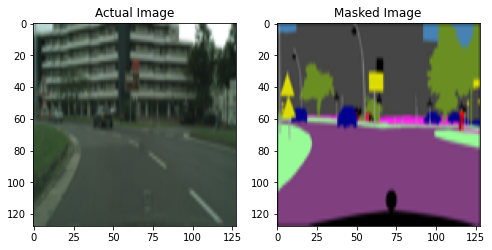

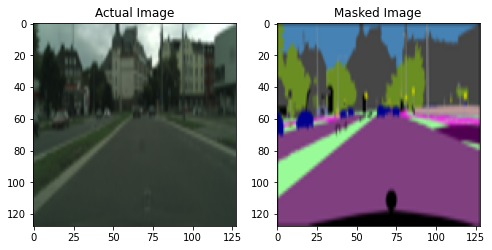

In [11]:
for img, gt in list(zip(im_train_ds.take(2), gt_train_ds.take(2))):
    visualize_images(img, gt, None)

# Kmeans model and functions

In [12]:
# data transformation using K-means
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), 
              (0,255,255), (255,255,255), (200,50,0),(50,200,0), (50,0,200), 
              (200,200,50), (0,50,200), (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg
    
def train_kmeans(K=13):
    colors = []
    kmeans_gt_train_paths = [GT_DIR + 'train/' + path for path in listdir(GT_DIR + 'train/')[:20]]
    kmeans_gt_train_ds = tf.data.Dataset.from_tensor_slices(kmeans_gt_train_paths)
    kmeans_gt_train_ds = kmeans_gt_train_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    for seg in kmeans_gt_train_ds:
        colors.append(tf.reshape(seg, (seg.shape[0]*seg.shape[1], 3) ))
    colors = tf.concat(colors, 0) 
    print("Training K means on colors data of shape :",colors.shape)
    km = KMeans(K)
    km.fit(colors)
    print("\nK-means clustering trained\n", km)
    return km

# Traing a k-means classifier
km=train_kmeans(13)

def load_and_preprocess_segment(path):
    seg = load_and_preprocess_image(path)
    s = tf.reshape(seg, (seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = tf.reshape(s, (seg.shape[0], seg.shape[1]))
    n = len(km.cluster_centers_)
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        cls[:,:,i]=m

    seg = tf.convert_to_tensor(cls, dtype=tf.float32)
    return seg

Training K means on colors data of shape : (327680, 3)

K-means clustering trained
 KMeans(n_clusters=13)


# Preparing Data Splits

In [13]:
# train data
im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'train/'))
im_train_ds = im_train_ds.map(load_and_preprocess_image)

gt_train_paths = get_image_paths(GT_DIR+'train/')
gt_train_ds = map(load_and_preprocess_segment, gt_train_paths)
gt_train_ds = tf.data.Dataset.from_tensor_slices([a for a in gt_train_ds])
train_ds = tf.data.Dataset.zip((im_train_ds, gt_train_ds))
im_train_ds = gt_train_ds = None
train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

print('Training Data:\n# of batches, Input batch shape, Ouput batch shape')
print(len(train_ds), next(iter(train_ds))[0].shape, next(iter(train_ds))[1].shape)

Training Data:
# of batches, Input batch shape, Ouput batch shape
93 (32, 128, 128, 3) (32, 128, 128, 13)


In [14]:
# val data
im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'val/'))
im_val_ds = im_val_ds.map(load_and_preprocess_image)

gt_val_paths = get_image_paths(GT_DIR+'val/')
gt_val_ds = map(load_and_preprocess_segment, gt_val_paths)
gt_val_ds = tf.data.Dataset.from_tensor_slices([a for a in gt_val_ds])
val_ds = tf.data.Dataset.zip((im_val_ds, gt_val_ds))
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


print('Validation Data:\n# of batches, Input batch shape, Ouput batch shape')
print(len(val_ds), next(iter(val_ds))[0].shape, next(iter(val_ds))[1].shape)

Validation Data:
# of batches, Input batch shape, Ouput batch shape
16 (32, 128, 128, 3) (32, 128, 128, 13)


In [15]:
# test data
im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'test/'))
im_test_ds = im_test_ds.map(load_and_preprocess_image)

gt_test_paths = get_image_paths(GT_DIR+'test/')
gt_test_ds = map(load_and_preprocess_segment, gt_test_paths)
gt_test_ds = tf.data.Dataset.from_tensor_slices([a for a in gt_test_ds])
test_ds = tf.data.Dataset.zip((im_test_ds, gt_test_ds))
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

print('Testing Data:\n# of batches, Input batch shape, Ouput batch shape')
print(len(test_ds), next(iter(test_ds))[0].shape, next(iter(test_ds))[1].shape)

Testing Data:
# of batches, Input batch shape, Ouput batch shape
48 (32, 128, 128, 3) (32, 128, 128, 13)


In [16]:
print(im_test_ds)
print(gt_test_ds)

<MapDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>
<TensorSliceDataset element_spec=TensorSpec(shape=(128, 128, 13), dtype=tf.float32, name=None)>


# **Unet Model**

# 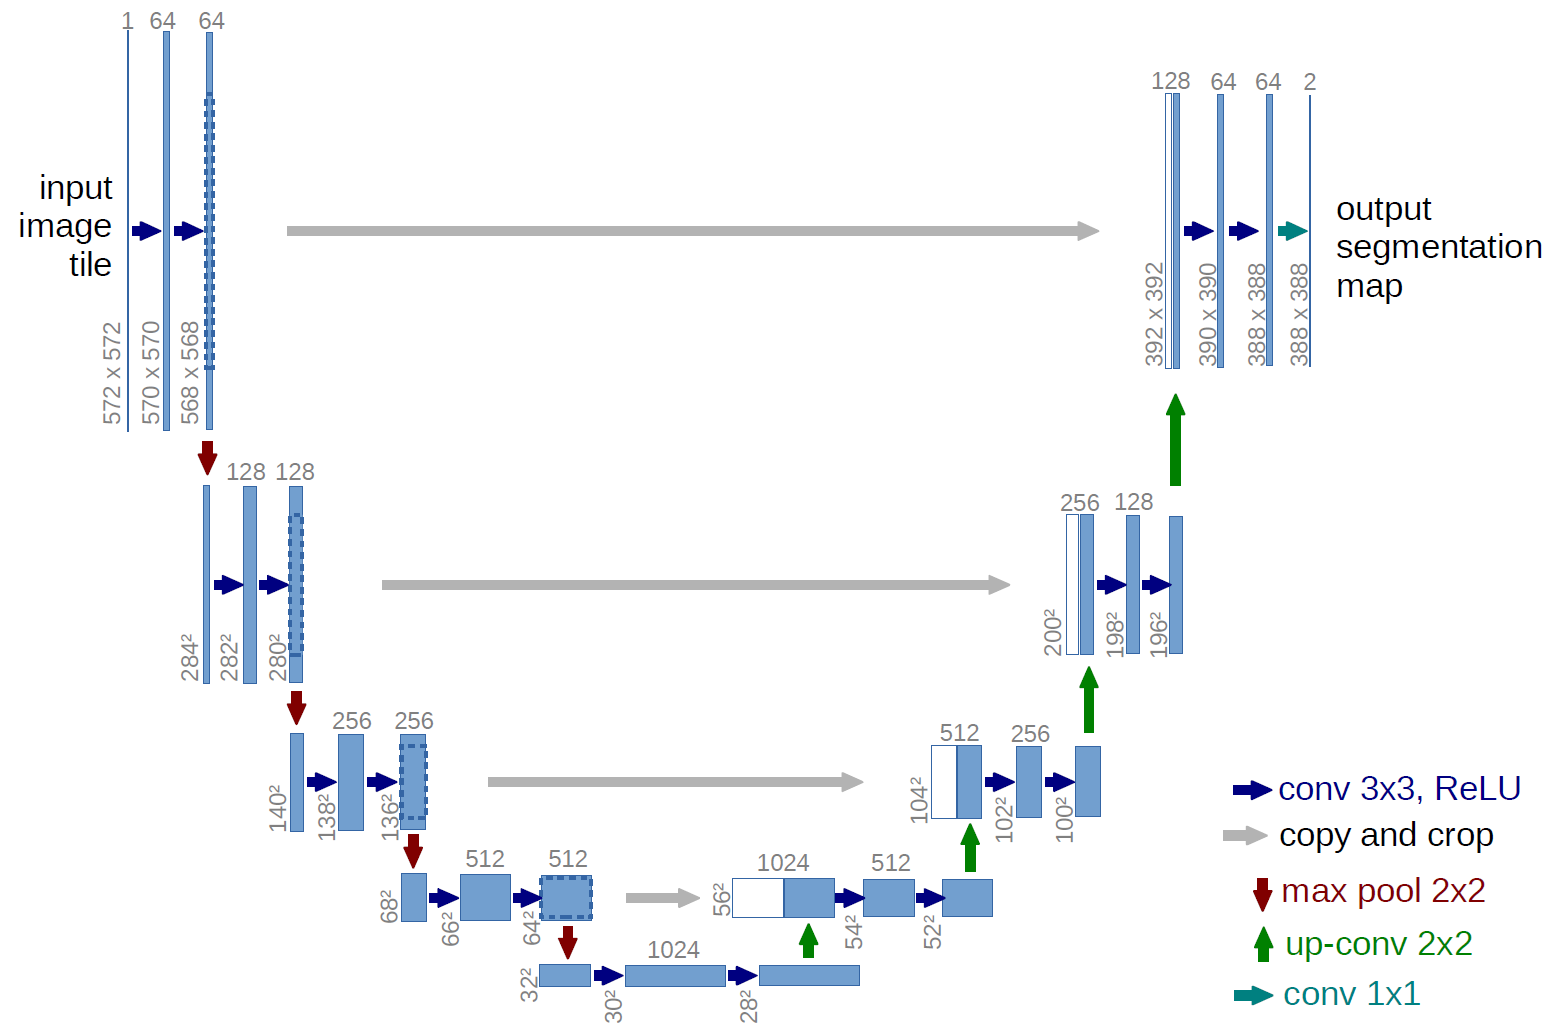

### Model Definition

In [17]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [23]:
def build_unet_model():
 # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   f1, p1 = downsample_block(inputs, 32)
   f2, p2 = downsample_block(p1, 64)
   f3, p3 = downsample_block(p2, 128)

   # 5 - bottleneck
   bottleneck = double_conv_block(p3, 256)

   # decoder: expanding path - upsample
   u6 = upsample_block(bottleneck, f3, 128)
   u7 = upsample_block(u6, f2, 64)
   u8 = upsample_block(u7, f1, 32)

   # outputs
   outputs = layers.Conv2D(13, 1, padding="same", activation = "softmax")(u8)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [24]:
model = build_unet_model()

In [25]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 128, 128, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_30[0][0]']              
                                )                                                             

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")

### Model Training & Evaluation

In [ ]:
NUM_EPOCHS = 20

TRAIN_LENGTH = 93
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = 48
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_ds,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=val_ds)

Epoch 1/20
2/2 [==============================] - 28s 13s/step - loss: 2.5822 - accuracy: 0.0633
Epoch 2/20
2/2 [==============================] - 27s 13s/step - loss: 2.4226 - accuracy: 0.2123
Epoch 3/20
2/2 [==============================] - 29s 16s/step - loss: 2.3529 - accuracy: 0.2963
Epoch 4/20
2/2 [==============================] - 26s 13s/step - loss: 2.2587 - accuracy: 0.3211
Epoch 5/20
2/2 [==============================] - 26s 13s/step - loss: 2.1446 - accuracy: 0.3150
Epoch 6/20
2/2 [==============================] - 26s 13s/step - loss: 2.2056 - accuracy: 0.3250
Epoch 7/20
2/2 [==============================] - 26s 13s/step - loss: 2.1564 - accuracy: 0.3350
Epoch 8/20
2/2 [==============================] - 28s 15s/step - loss: 2.1337 - accuracy: 0.3364
Epoch 9/20
2/2 [==============================] - 26s 13s/step - loss: 2.0814 - accuracy: 0.3241
Epoch 10/20
2/2 [==============================] - 26s 13s/step - loss: 2.0272 - accuracy: 0.3255
Epoch 11/20
2/2 [============

#### Prediction Visualization

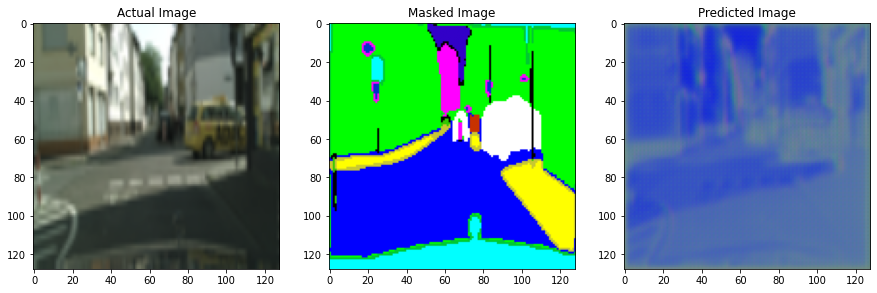

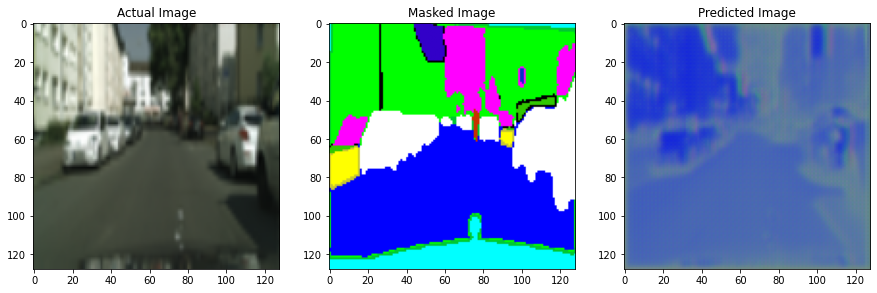

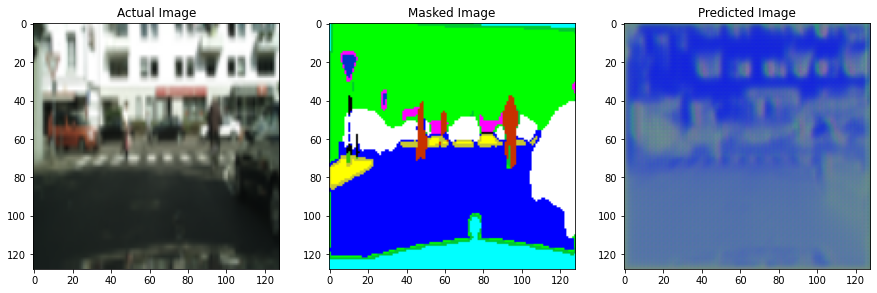

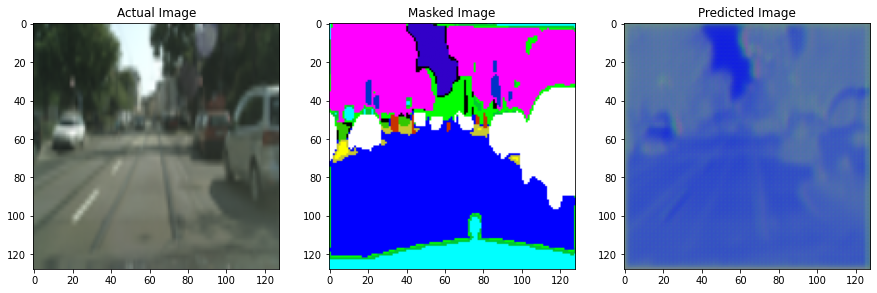

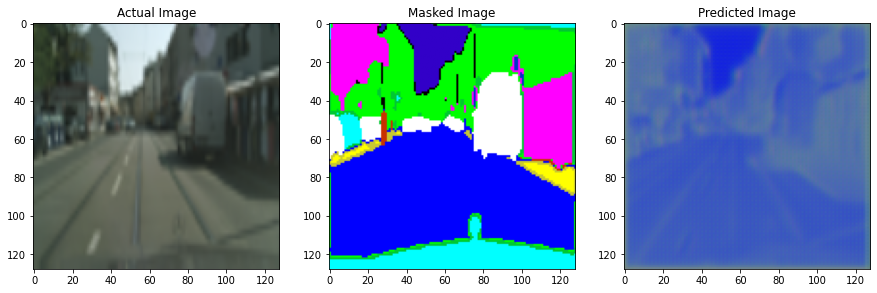

In [ ]:
max_show=4
for imgs, segs in val_ds:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        predimg = _p
        trueimg = _s

        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.title("Actual Image")
        plt.imshow(imgs[i])

        plt.subplot(132)
        plt.title("Masked Image")
        plt.imshow(_s)
        # plt.axis("off")

        plt.subplot(133)
        plt.title("Predicted Image")
        plt.imshow(_p)
        # plt.tight_layout()

        plt.show()
    break

### Further Training

In [26]:
# loading trained model
checkpoint_path_old = drive_root+'cpt_27july/cp.ckpt'
checkpoint_dir_old = os.path.dirname(checkpoint_path_old)
# load model
model = build_unet_model()

model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy", #sparse for 2d
                  metrics="accuracy")

model.load_weights(checkpoint_path_old)
# Re-evaluate loaded model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

16/16 - 46s - loss: 2.8948 - accuracy: 0.3439 - 46s/epoch - 3s/step
Restored model, accuracy: 34.39%


In [ ]:
# retrain model
checkpoint_path = drive_root+'cpt_28july/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(train_ds, epochs=2, validation_data=val_ds, verbose=1, callbacks=[cp_callback]) 

model.save(drive_root+'trained_model_28july.h5')

loss, acc = model.evaluate(val_ds, verbose=2)
print("Retrained model, accuracy: {:5.2f}%".format(100 * acc))

Epoch 1/2
93/93 [==============================] - ETA: 0s - loss: 1.1749 - accuracy: 0.6365 
Epoch 1: saving model to /gdrive/My Drive/College/Cars/cpt_27july/cp.ckpt
93/93 [==============================] - 1350s 14s/step - loss: 1.1749 - accuracy: 0.6365 - val_loss: 1.1879 - val_accuracy: 0.6518
Epoch 2/2
93/93 [==============================] - ETA: 0s - loss: 1.4493 - accuracy: 0.6205 
Epoch 2: saving model to /gdrive/My Drive/College/Cars/cpt_27july/cp.ckpt
93/93 [==============================] - 1363s 15s/step - loss: 1.4493 - accuracy: 0.6205 - val_loss: 1.2060 - val_accuracy: 0.6326
16/16 - 53s - loss: 1.2060 - accuracy: 0.6326 - 53s/epoch - 3s/step
Retrained model, accuracy: 63.26%


#### Prediction Visualization

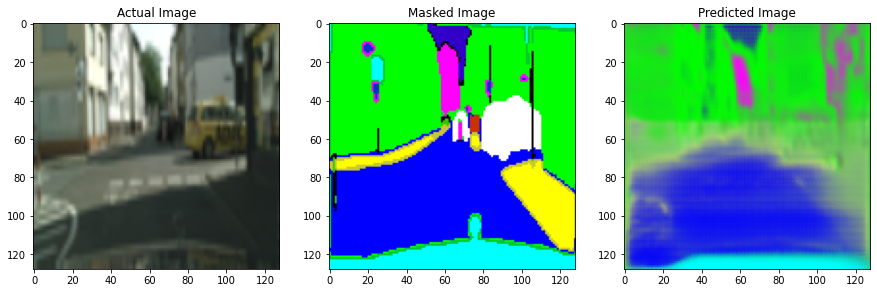

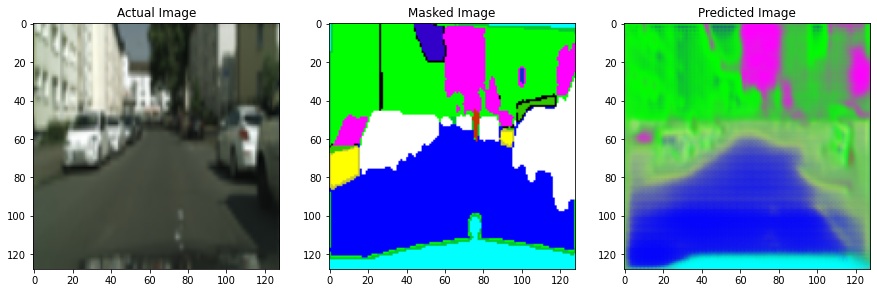

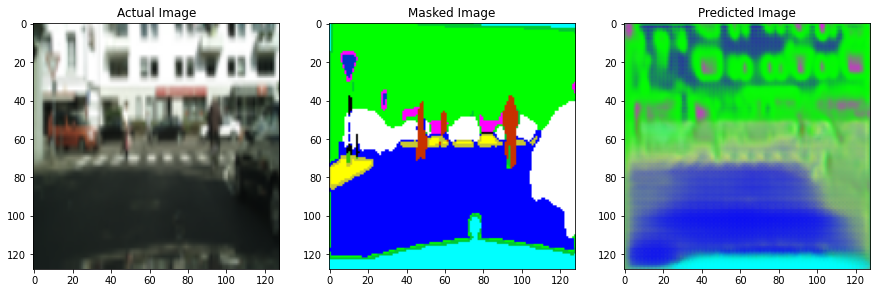

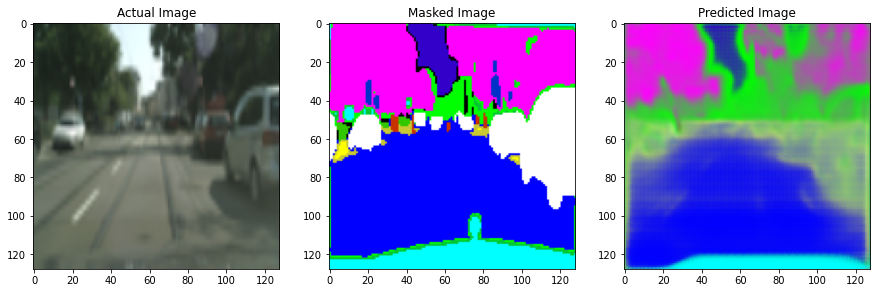

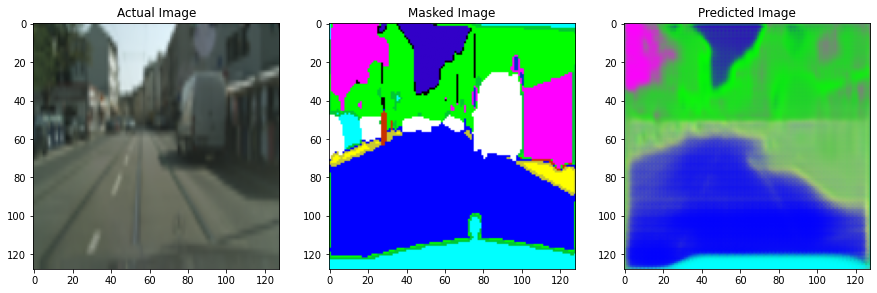

In [ ]:
max_show=4
for imgs, segs in val_ds:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        predimg = _p
        trueimg = _s

        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.title("Actual Image")
        plt.imshow(imgs[i])

        plt.subplot(132)
        plt.title("Masked Image")
        plt.imshow(_s)
        # plt.axis("off")

        plt.subplot(133)
        plt.title("Predicted Image")
        plt.imshow(_p)
        # plt.tight_layout()

        plt.show()
    break

### **Evaluation on Video & Images**

*code to leverage the trained model to provide real road scene prediction from video and images.*

In [ ]:
from google.colab.patches import cv2_imshow
vidcap = cv2.VideoCapture('carssss.mp4') # upload file
success, image = vidcap.read()
count = 0

# video to frames generation
while success:
    cv2.imwrite('orig_frame_%.3d.jpg' % count, image)  # save frame as JPEG file
    success, image = vidcap.read()
    count += 1

frames = [img for img in get_image_paths(COLAB_DIR) if img.endswith('.jpg')]

def convert_to_video(image_paths, video_name):
    frame = cv2.imread(image_paths[0])
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, 0, 30, (width,height))
    for image in image_paths:
        video.write(cv2.imread(image))
    
    cv2.destroyAllWindows()
    video.release()
  
# model predictions on generated frames
eval_ds2 = tf.data.Dataset.from_tensor_slices(frames)
eval_ds2 = eval_ds2.map(load_and_preprocess_image)
eval_ds2 = eval_ds2.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
convert_to_video(frames, 'original_video.avi')

pred_frames = model.predict(eval_ds2)
count = 0
for image in pred_frames:
    image = LayersToRGBImage(image)
    plt.imsave('pred_frame_%.3d.png' % count, image)
    count += 1
# converting predictions to a video back
frames = [img for img in get_image_paths(COLAB_DIR) if img.endswith('.png')]
convert_to_video(frames, 'predicted_video.avi')

In [ ]:
from google.colab.patches import cv2_imshow
vidcap = cv2.VideoCapture('carssss2.mp4') # upload file
success, image = vidcap.read()
count = 0

# video to frames generation
while success:
    cv2.imwrite('korig_frame_%.3d.jpg' % count, image)  # save frame as JPEG file
    success, image = vidcap.read()
    count += 1

frames = [img for img in get_image_paths(COLAB_DIR) if img.startswith('/content/korig')]

def convert_to_video(image_paths, video_name):
    frame = cv2.imread(image_paths[0])
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, 0, 30, (width,height))
    for image in image_paths:
        video.write(cv2.imread(image))
    
    cv2.destroyAllWindows()
    video.release()
  
# model predictions on generated frames
eval_ds2 = tf.data.Dataset.from_tensor_slices(frames)
eval_ds2 = eval_ds2.map(load_and_preprocess_image)
eval_ds2 = eval_ds2.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
convert_to_video(frames, 'koriginal_video.avi')

pred_frames = model.predict(eval_ds2)
count = 0
for image in pred_frames:
    image = LayersToRGBImage(image)
    plt.imsave('kpred_frame_%.3d.png' % count, image)
    count += 1
# converting predictions to a video back
frames = [img for img in get_image_paths(COLAB_DIR) if img.startswith('/content/kpred')]
convert_to_video(frames, 'kpredicted_video.avi')

#### **Videos downloaded as issue with cv2.imshow in Google Colab**

#### **Images**

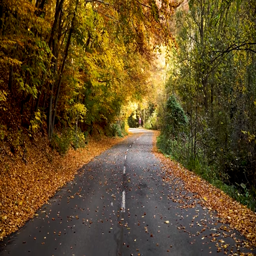

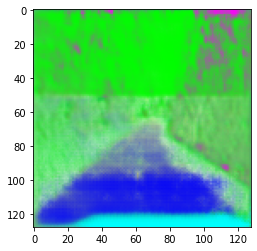

In [28]:
image = Image.open("/content/road_tree.png").resize((256,256))
display(image)

#-----------

frames = ['/content/road_tree.png']
# model predictions on generated frames
eval_ds2 = tf.data.Dataset.from_tensor_slices(frames)
eval_ds2 = eval_ds2.map(load_and_preprocess_image)
eval_ds2 = eval_ds2.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

pred_frames = model.predict(eval_ds2)
count = 0
for image in pred_frames:
    image = LayersToRGBImage(image)
    plt.imsave('road_tree_pred.png', image)
    image = Image.open("/content/road_tree_pred.png")
    plt.imshow(image)

In [29]:
# Saving the code as a function
def compare(path):
    image = Image.open(path).resize((256,256))
    display(image)

    #-----------

    frames = [path]
    # model predictions
    eval_ds2 = tf.data.Dataset.from_tensor_slices(frames)
    eval_ds2 = eval_ds2.map(load_and_preprocess_image)
    eval_ds2 = eval_ds2.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    pred_frames = model.predict(eval_ds2)
    count = 0
    for image in pred_frames:
        image = LayersToRGBImage(image)
        plt.imshow(image)

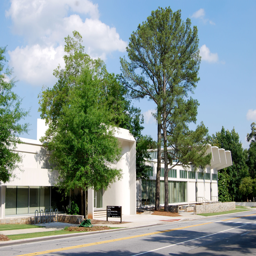

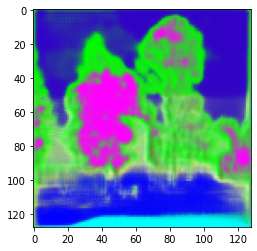

In [ ]:
compare('/content/building.jpg')

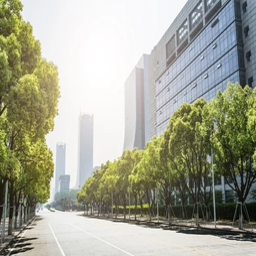

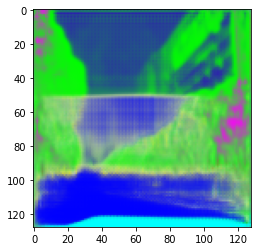

In [ ]:
compare('/content/road.png')

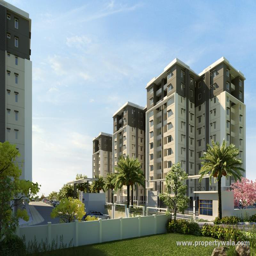

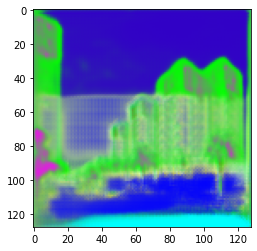

In [ ]:
compare('/content/tree.jpg')

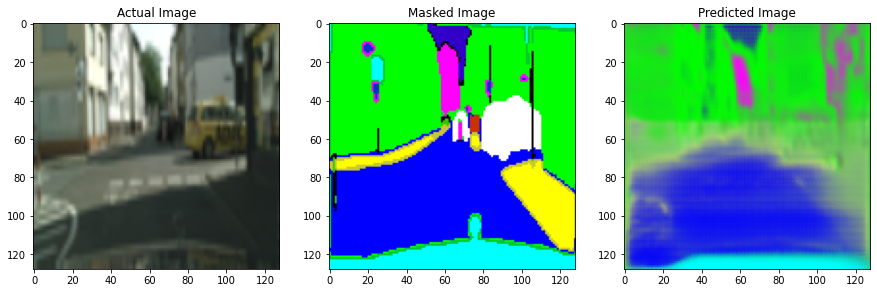

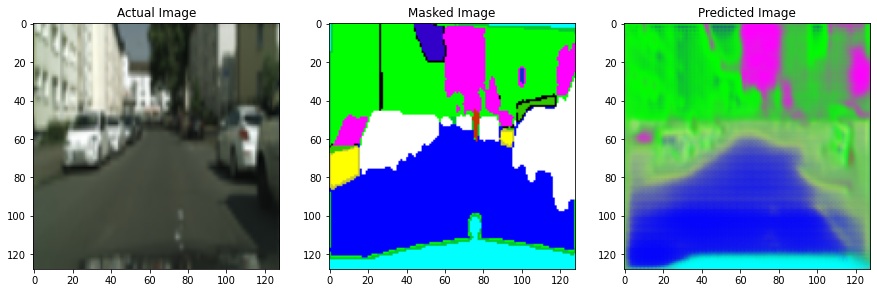

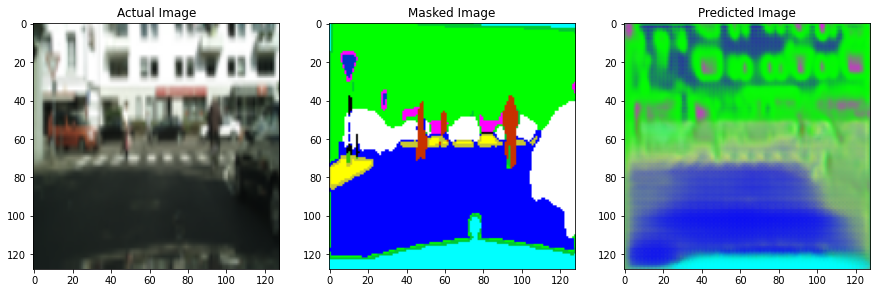

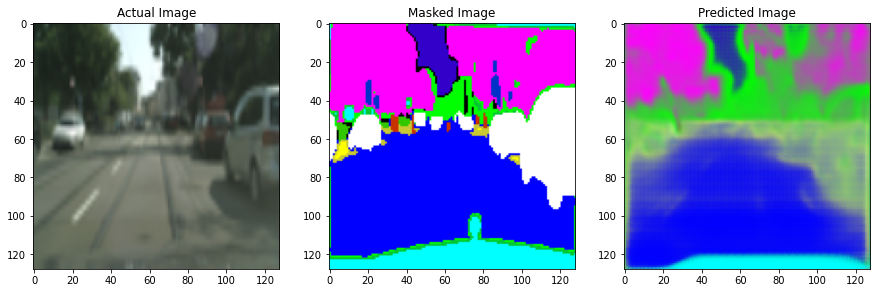

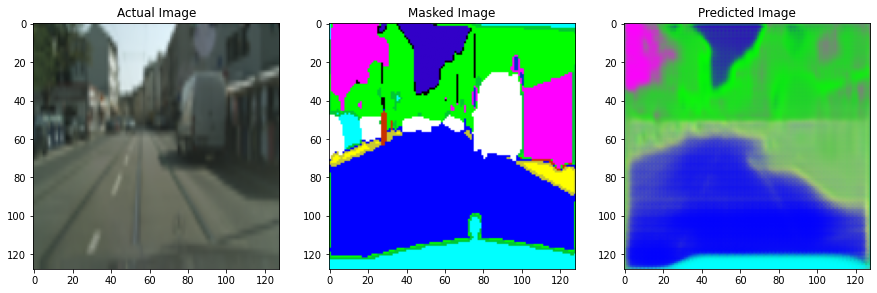

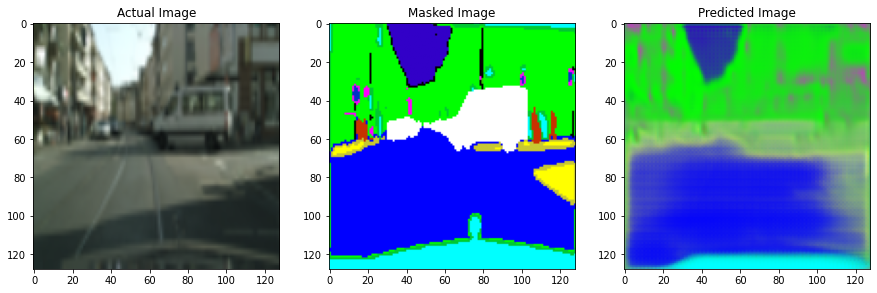

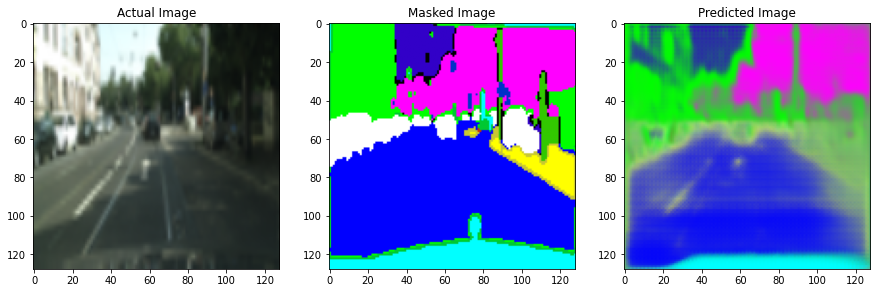

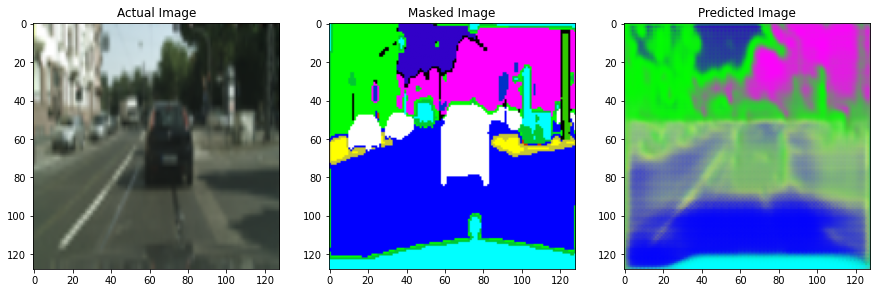

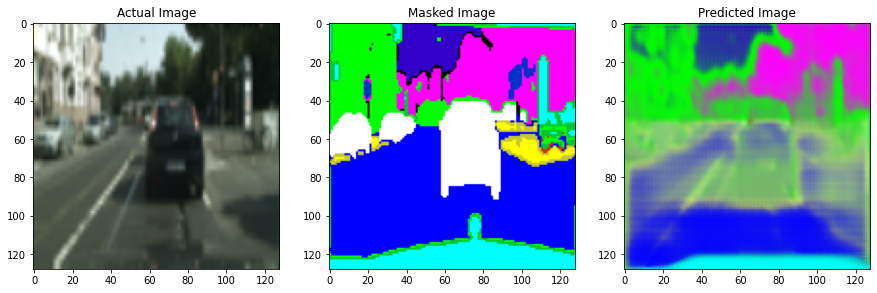

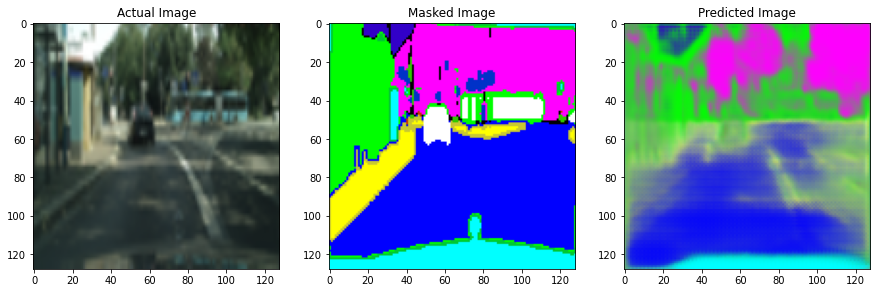

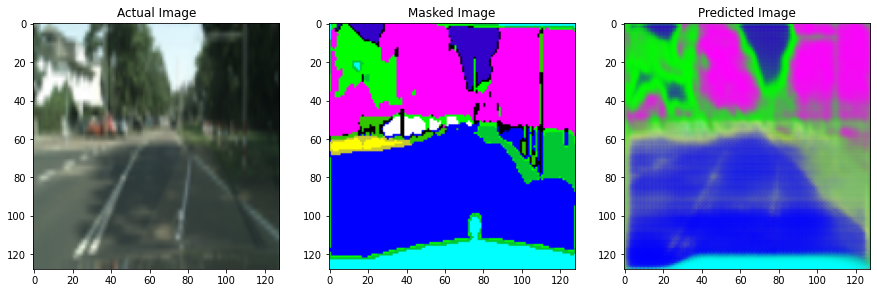

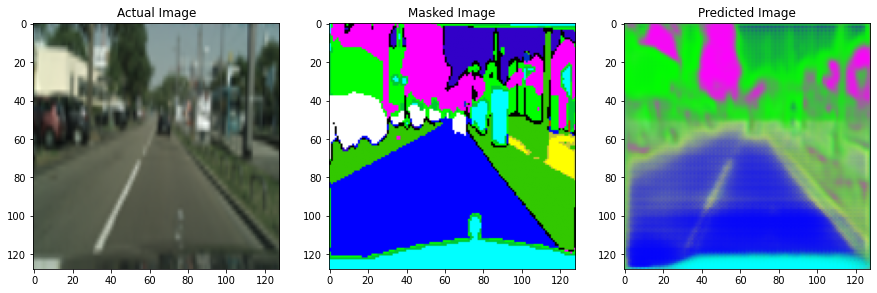

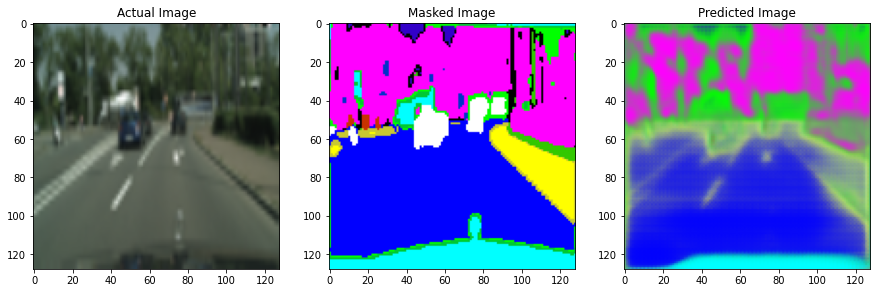

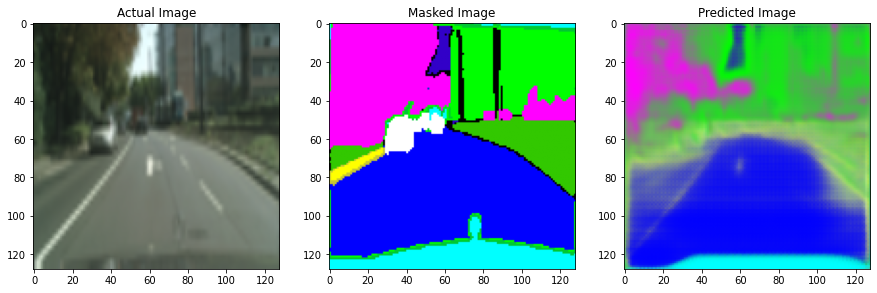

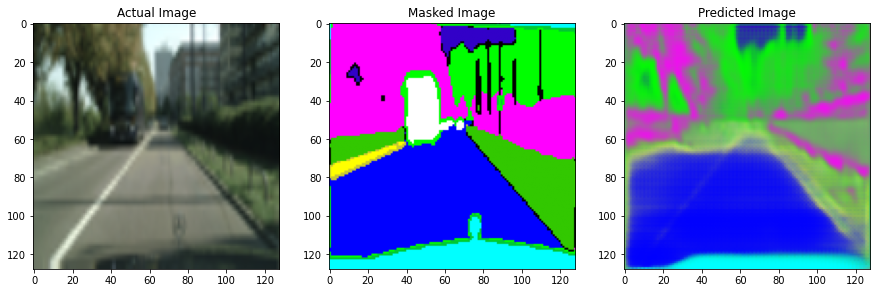

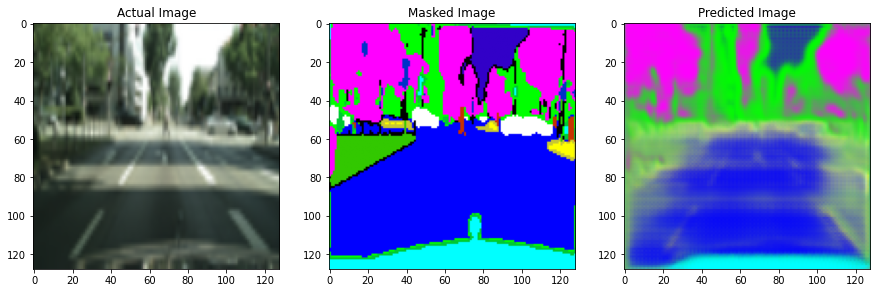

In [ ]:
#model test
max_show=15
for imgs, segs in val_ds:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        predimg = _p
        trueimg = _s

        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.title("Actual Image")
        plt.imshow(imgs[i])

        plt.subplot(132)
        plt.title("Masked Image")
        plt.imshow(_s)
        # plt.axis("off")

        plt.subplot(133)
        plt.title("Predicted Image")
        plt.imshow(_p)
        # plt.tight_layout()

        plt.show()
    break

### **Accuracy**
Further training did not improve accuracy of the model and beyond a point it started to reduce possibly due to overfitting. Attempting to improve accuracy with bigger models (that is with more layers and parameters)

In [ ]:
def build_bigger_unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   f1, p1 = downsample_block(inputs, 32)
   f2, p2 = downsample_block(p1, 64)
   f3, p3 = downsample_block(p2, 128)
   f4, p4 = downsample_block(p3, 256)
   f5, p5 = downsample_block(p4, 512)

   # bottleneck
   bottleneck = double_conv_block(p5, 1024)

   # decoder: expanding path - upsample
   u6 = upsample_block(bottleneck, f5, 512)
   u7 = upsample_block(u6, f4, 256)
   u8 = upsample_block(u7, f3, 128)
   u9 = upsample_block(u8, f2, 64)
   u10 = upsample_block(u9, f1, 32)

   # outputs
   outputs = layers.Conv2D(13, 1, padding="same", activation = "softmax")(u10)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [ ]:
big_model = build_bigger_unet_model()
big_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_217 (Conv2D)            (None, 128, 128, 32  896         ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_218 (Conv2D)            (None, 128, 128, 32  9248        ['conv2d_217[0][0]']             
                                )                                                             

In [ ]:
big_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
NUM_EPOCHS = 20

TRAIN_LENGTH = 93
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = 48
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = big_model.fit(train_ds,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=val_ds)

Epoch 1/20
2/2 [==============================] - 52s 23s/step - loss: 2.5302 - accuracy: 0.1427
Epoch 2/20
2/2 [==============================] - 48s 24s/step - loss: 2.3613 - accuracy: 0.2677
Epoch 3/20
2/2 [==============================] - 45s 23s/step - loss: 2.2591 - accuracy: 0.3040
Epoch 4/20
2/2 [==============================] - 45s 23s/step - loss: 16.3362 - accuracy: 0.3134
Epoch 5/20
2/2 [==============================] - 45s 23s/step - loss: 2.1822 - accuracy: 0.3239
Epoch 6/20
2/2 [==============================] - 46s 23s/step - loss: 2.2643 - accuracy: 0.2519
Epoch 7/20
2/2 [==============================] - 45s 22s/step - loss: 2.2589 - accuracy: 0.1477
Epoch 8/20
2/2 [==============================] - 44s 22s/step - loss: 2.2430 - accuracy: 0.2123
Epoch 9/20
2/2 [==============================] - 45s 22s/step - loss: 2.2512 - accuracy: 0.1761
Epoch 10/20
2/2 [==============================] - 44s 22s/step - loss: 2.2142 - accuracy: 0.1940
Epoch 11/20
2/2 [===========

In [ ]:
def build_bigger_unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   f1, p1 = downsample_block(inputs, 32)
   f2, p2 = downsample_block(p1, 64)
   f3, p3 = downsample_block(p2, 128)
   f4, p4 = downsample_block(p3, 256)

   # bottleneck
   bottleneck = double_conv_block(p4, 512)

   # decoder: expanding path - upsample
   u7 = upsample_block(bottleneck, f4, 256)
   u8 = upsample_block(u7, f3, 128)
   u9 = upsample_block(u8, f2, 64)
   u10 = upsample_block(u9, f1, 32)


   # outputs
   outputs = layers.Conv2D(13, 1, padding="same", activation = "softmax")(u10)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [ ]:
big_model = build_bigger_unet_model()
big_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_240 (Conv2D)            (None, 128, 128, 32  896         ['input_19[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_241 (Conv2D)            (None, 128, 128, 32  9248        ['conv2d_240[0][0]']             
                                )                                                             

In [ ]:
big_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
NUM_EPOCHS = 20

TRAIN_LENGTH = 93
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = 48
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = big_model.fit(train_ds,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=val_ds)

Epoch 1/20
2/2 [==============================] - 88s 17s/step - loss: 2.5680 - accuracy: 0.1540
Epoch 2/20
2/2 [==============================] - 34s 17s/step - loss: 2.3854 - accuracy: 0.2042
Epoch 3/20
2/2 [==============================] - 34s 17s/step - loss: 2.3417 - accuracy: 0.2120
Epoch 4/20
2/2 [==============================] - 34s 17s/step - loss: 2.2936 - accuracy: 0.2329
Epoch 5/20
2/2 [==============================] - 33s 17s/step - loss: 2.0860 - accuracy: 0.3277
Epoch 6/20
2/2 [==============================] - 34s 17s/step - loss: 2.1881 - accuracy: 0.2432
Epoch 7/20
2/2 [==============================] - 33s 17s/step - loss: 2.1041 - accuracy: 0.3192
Epoch 8/20
2/2 [==============================] - 33s 17s/step - loss: 2.0732 - accuracy: 0.3399
Epoch 9/20
2/2 [==============================] - 34s 17s/step - loss: 2.0426 - accuracy: 0.3498
Epoch 10/20
2/2 [==============================] - 35s 19s/step - loss: 2.0670 - accuracy: 0.3385
Epoch 11/20
2/2 [============

In [ ]:
# retrain model
checkpoint_path = drive_root+'cpt_27july_eve/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
big_model.fit(train_ds, epochs=2, validation_data=val_ds, verbose=1, callbacks=[cp_callback]) 

model.save(drive_root+'trained_model_27july_eve2.h5')

loss, acc = big_model.evaluate(val_ds, verbose=2)
print("Retrained model, accuracy: {:5.2f}%".format(100 * acc))

Epoch 1/2
93/93 [==============================] - ETA: 0s - loss: 1.0495 - accuracy: 0.6580 
Epoch 1: saving model to /gdrive/My Drive/College/Cars/cpt_27july_eve/cp.ckpt
93/93 [==============================] - 1675s 18s/step - loss: 1.0495 - accuracy: 0.6580 - val_loss: 1.0318 - val_accuracy: 0.6558
Epoch 2/2
93/93 [==============================] - ETA: 0s - loss: 1.1271 - accuracy: 0.6522 
Epoch 2: saving model to /gdrive/My Drive/College/Cars/cpt_27july_eve/cp.ckpt
93/93 [==============================] - 1687s 18s/step - loss: 1.1271 - accuracy: 0.6522 - val_loss: 2.4789 - val_accuracy: 0.5079
16/16 - 67s - loss: 2.4789 - accuracy: 0.5079 - 67s/epoch - 4s/step
Retrained model, accuracy: 50.79%


### **Key observations**
Buildings, Trees, Road and Sky are appropriately predicted/recognised. Difficulty in recognising the vehicles.

Accuracy does not improve further. Need higher resources to work on uncompressed / lesser compressed images for better accuracy and prediction of vehicles.